Colab

In [1]:
# 1. 구글 드라이브 마운트 (파일 접근용)
from google.colab import drive
drive.mount('/content/drive')

# 2. 작업 경로 변경 (중요: 이걸 해야 asset 폴더를 찾을 수 있음)
import os
# 이미지에 보이는 경로로 이동합니다.
os.chdir('/content/drive/MyDrive/js_mujoco/tutorial')

# 3. 필수 패키지 설치 (매번 실행해줘야 함)
# 시스템 패키지 (EGL, ffmpeg)
!apt-get update
!apt-get install -y libgl1-mesa-dev libgl1-mesa-glx libglew-dev \
libosmesa6-dev software-properties-common patchelf \
libegl1-mesa-dev ffmpeg

# 파이썬 패키지
!pip install mujoco mediapy gymnasium stable-baselines3

ModuleNotFoundError: No module named 'google.colab'

1. 환경 & 라이브러리

In [1]:
import os
import sys

# 1. 지금 실행 중인 곳이 Google Colab인지 확인
if 'google.colab' in sys.modules:
    print("Running on Colab: Using EGL")
    os.environ['MUJOCO_GL'] = 'egl'
else:
    # 2. 로컬 PC(우분투)라면 창 모드(GLFW) 사용
    print("Running on Local: Using GLFW")
    os.environ['MUJOCO_GL'] = 'glfw'
 
import mujoco
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

Running on Local: Using GLFW


2. XML 정의

In [2]:
xml = """
<mujoco model="inverted pendulum">
    <compiler inertiafromgeom="true"/>
    <default>
        <joint armature="0" damping="1" limited="true"/>
        <geom friction="1 0.1 0.1" rgba="0.7 0.7 0 1"/>
        <tendon/>
        <motor ctrlrange="-3 3"/>
    </default>
    <option gravity="0 0 -9.81" integrator="Euler" timestep="0.01"/>
    <size nstack="3000"/>
    <worldbody>
        <!-- 레일 (바닥) -->
        <geom name="rail" pos="0 0 0" quat="0.707 0 0.707 0" rgba="0.3 0.3 0.7 1"
              size="0.02 1" type="capsule" contype="0" conaffinity="0"/>
        
        <!-- 움직이는 카트 (Cart) -->
        <body name="cart" pos="0 0 0">
            <!-- 슬라이드 조인트: 직선 운동 -->
            <joint axis="1 0 0" limited="true" name="slider" pos="0 0 0"
                   range="-1.2 1.2" type="slide"/>
            <geom name="cart" pos="0 0 0" quat="0.707 0 0.707 0"
                  size="0.1 0.1" type="capsule"/>
            
            <!-- 카트 위의 막대 (Pole) -->
            <body name="pole" pos="0 0 0">
                <!-- 힌지 조인트: 회전 운동 -->
                <joint axis="0 1 0" name="hinge" pos="0 0 0"
                       type="hinge" limited="false"/>
                <geom fromto="0 0 0 0.001 0 0.6" name="cpole"
                      rgba="0 0.7 0.7 1" size="0.049 0.3" type="capsule"/>
            </body>
        </body>
    </worldbody>
    <!-- 액추에이터: 카트를 미는 모터 -->
    <actuator>
        <motor ctrllimited="true" ctrlrange="-3 3" gear="10"
               joint="slider" name="slide"/>
    </actuator>
</mujoco>
"""

Env 관련 유틸 함수들

In [3]:
def create_env():
    """MuJoCo 모델/데이터/렌더러 생성."""
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model, height=480, width=640)
    return model, data, renderer


def reset_state(data, q_init=None, qv_init=None):
    """qpos, qvel 초기화. q_init, qv_init은 리스트나 np.array로 전달."""
    mujoco.mj_resetData(data.model, data)
    if q_init is not None:
        data.qpos[:len(q_init)] = q_init
    if qv_init is not None:
        data.qvel[:len(qv_init)] = qv_init
    mujoco.mj_forward(data.model, data)


def get_state(data):
    """
    상태 벡터 [x_cart, theta_pole, x_dot, theta_dot] 반환.
    qpos[0] : slider joint (cart position)
    qpos[1] : hinge joint (pole angle)
    """
    x = float(data.qpos[0])
    theta = float(data.qpos[1])
    x_dot = float(data.qvel[0])
    theta_dot = float(data.qvel[1])
    return np.array([x, theta, x_dot, theta_dot])


def rollout(model, data, renderer,
            duration=10.0, framerate=60,
            ctrl_func=None,
            q_init=None, qv_init=None):
    """
    한 에피소드 시뮬레이션:
      - ctrl_func(state, t)로 제어 입력 생성 (None이면 0 입력)
      - 상태 궤적과 프레임 기록.

    반환:
      times, states, controls, frames
    """
    reset_state(data, q_init=q_init, qv_init=qv_init)

    dt = model.opt.timestep
    times = []
    states = []
    controls = []
    frames = []

    # 메인 루프
    while data.time < duration:
        t = float(data.time)
        state = get_state(data)

        # 제어 입력 계산
        if ctrl_func is None:
            u = 0.0
        else:
            u = float(ctrl_func(state, t))

        # ctrl 적용
        data.ctrl[0] = u

        # 한 스텝 진행
        mujoco.mj_step(model, data)

        # 로깅
        times.append(t)
        states.append(state)
        controls.append(u)

        # 프레임 샘플링 (대략 framerate에 맞추기)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)

    return (
        np.array(times),
        np.vstack(states),   # shape: [T, 4]
        np.array(controls),  # shape: [T]
        np.array(frames)     # shape: [N_frames, H, W, 3]
    )

def plot_states(times, states, controls=None, title="Cart-Pole States"):
    """
    states: shape [T, 4] = [x, theta, x_dot, theta_dot]
    controls: shape [T] or None
    """
    x = states[:, 0]
    theta = states[:, 1]
    x_dot = states[:, 2]
    theta_dot = states[:, 3]

    if controls is None:
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(title, fontsize=16)

        axs[0, 0].plot(times, x, label="Cart Position [m]")
        axs[0, 0].set_ylabel("Position [m]")
        axs[0, 0].set_title("Cart Position")
        axs[0, 0].grid(True)
        axs[0, 0].legend()

        axs[0, 1].plot(times, x_dot, "r", label="Cart Velocity [m/s]")
        axs[0, 1].set_ylabel("Velocity [m/s]")
        axs[0, 1].set_title("Cart Velocity")
        axs[0, 1].grid(True)
        axs[0, 1].legend()

        axs[1, 0].plot(times, theta, "g", label="Pole Angle [rad]")
        axs[1, 0].set_ylabel("Angle [rad]")
        axs[1, 0].set_title("Pole Angle")
        axs[1, 0].set_xlabel("Time [s]")
        axs[1, 0].grid(True)
        axs[1, 0].legend()

        axs[1, 1].plot(times, theta_dot, "m", label="Pole Angular Velocity [rad/s]")
        axs[1, 1].set_ylabel("Angular Velocity [rad/s]")
        axs[1, 1].set_title("Pole Angular Velocity")
        axs[1, 1].set_xlabel("Time [s]")
        axs[1, 1].grid(True)
        axs[1, 1].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    else:
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        fig.suptitle(title, fontsize=16)

        axs[0].plot(times, x, label="Cart Position [m]")
        axs[0].plot(times, theta, label="Pole Angle [rad]")
        axs[0].set_ylabel("Pos / Angle")
        axs[0].grid(True)
        axs[0].legend()

        axs[1].plot(times, x_dot, label="Cart Velocity [m/s]")
        axs[1].plot(times, theta_dot, label="Pole Angular Velocity [rad/s]")
        axs[1].set_ylabel("Vel / Ang. Vel")
        axs[1].grid(True)
        axs[1].legend()

        axs[2].plot(times, controls, "r", label="Control Input [N]")
        axs[2].set_xlabel("Time [s]")
        axs[2].set_ylabel("Force [N]")
        axs[2].grid(True)
        axs[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

테스트: 제어 없이 시뮬레이션 + mediapy로 영상 보기

Simulation finished. Plotting states...


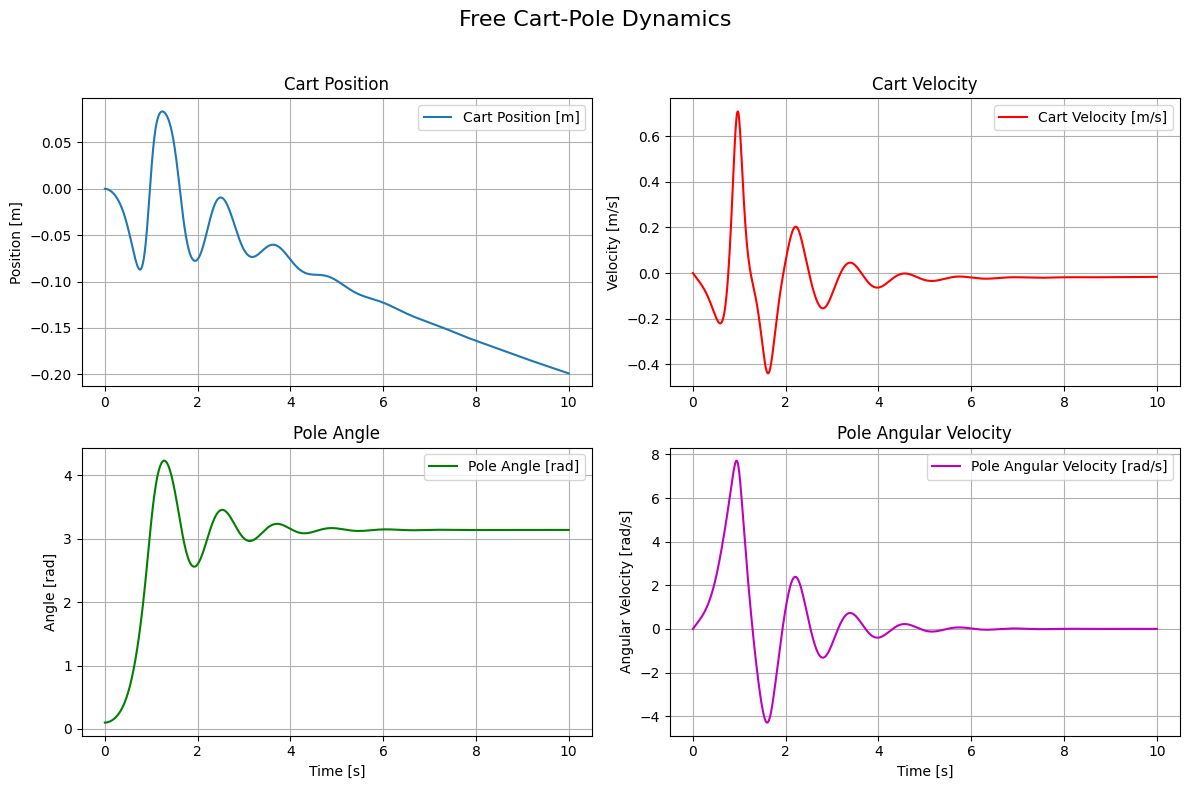

In [4]:
model, data, renderer = create_env()

# 초기 상태: 폴을 살짝(0.1 rad) 기울인 상태에서 시작
q_init = [0.0, 0.1]  # [x, theta]
qv_init = [0.0, 0.0]   # [x_dot, theta_dot]

duration = 10.0
framerate = 60

times, states, controls, frames = rollout(
    model, data, renderer,
    duration=duration,
    framerate=framerate,
    ctrl_func=None,     # 무제어
    q_init=q_init,
    qv_init=qv_init,
)

print("Simulation finished. Plotting states...")
plot_states(times, states, controls=None, title="Free Cart-Pole Dynamics")

In [5]:
print("Rendering video with mediapy...")
media.show_video(frames, fps=framerate)

Rendering video with mediapy...


***강화학습으로 제어하기***

Gym 스타일 환경 정의

In [ ]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

class CartPoleMuJoCoEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 60}

    def __init__(self, render_mode=None):
        super().__init__()
        # 기존 유틸 재사용
        self.model, self.data, self.renderer = create_env()
        self.dt = self.model.opt.timestep

        # 관측 공간: [x, theta, x_dot, theta_dot]
        high = np.array([np.inf, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        # 행동 공간: 카트에 가하는 힘 (연속, -3 ~ 3)
        self.action_space = spaces.Box(
            low=np.array([-3.0], dtype=np.float32),
            high=np.array([3.0], dtype=np.float32),
            dtype=np.float32,
        )

        self.render_mode = render_mode
        self.max_steps = int(10.0 / self.dt)  # 에피소드 최대 길이 (대략 10초)
        self.step_count = 0

    def _get_obs(self):
        return get_state(self.data).astype(np.float32)

    def _get_info(self):
        return {}

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0

        # 초기화 시 랜덤하게 약간 기울어지게 함 (-0.15 ~ 0.15 rad)
        theta0 = self.np_random.uniform(-0.15, 0.15)
        q_init = [0.0, theta0]
        qv_init = [0.0, 0.0]
        reset_state(self.data, q_init=q_init, qv_init=qv_init)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        self.step_count += 1

        # action은 shape (1,) 이라고 가정
        u = float(np.clip(action[0], -3.0, 3.0))
        self.data.ctrl[0] = u

        # 한 스텝 진행
        mujoco.mj_step(self.model, self.data)

        obs = self._get_obs()
        x, theta, x_dot, theta_dot = obs

        # 보상 설계 (Reward Shaping)
        # 폴이 세워져 있고 카트가 가운데에 있을수록 보상 높게
        cost = (
            1.0 * theta**2 +        # 각도 제곱 (기울어질수록 페널티)
            0.1 * x**2 +            # 위치 제곱 (중앙에서 멀어질수록 페널티)
            0.01 * x_dot**2 +       # 속도 제곱 (너무 빨리 움직이면 페널티)
            0.01 * theta_dot**2 +
            0.001 * u**2            # 제어 입력 제곱 (힘을 많이 쓰면 페널티)
        )
        reward = 1.0 - cost  # 최대 1 근처, 상태가 나쁠수록 작아짐

        # 종료 조건
        terminated = bool(
            abs(theta) > np.pi / 2.0 or  # 폴이 90도 이상 기울어지면 실패
            abs(x) > 1.2                 # 레일 밖으로 나가면 종료
        )
        truncated = bool(self.step_count >= self.max_steps)

        info = self._get_info()
        return obs, reward, terminated, truncated, info

    def render(self):
        # PPO 학습 중에는 호출 안 해도 되고,
        # 나중에 평가할 때 rgb_array로 프레임 뽑는 데 씀
        self.renderer.update_scene(self.data)
        img = self.renderer.render()
        return img

    def close(self):
        pass

PPO 학습

In [8]:
# Gymnasium env 인스턴스 생성
env = CartPoleMuJoCoEnv()

# MlpPolicy: 관측 → MLP → 연속 행동
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=1024,
    batch_size=64,
    gamma=0.99,
)

# 학습 스텝 수는 상황 봐가면서 늘려도 됨 (예: 100_000 ~ 300_000)
model.learn(total_timesteps=150_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.7     |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 3696     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 91.5         |
|    ep_rew_mean          | 52.4         |
| time/                   |              |
|    fps                  | 2652         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0025587429 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    en

In [9]:
# 학습된 모델 저장
model.save("ppo_cartpole_mujoco")

학습된 정책 성능 보기 (mediapy + 상태 플롯)

Running Evaluation Episode...
Episode ended at step 999
Evaluation finished. Plotting states...


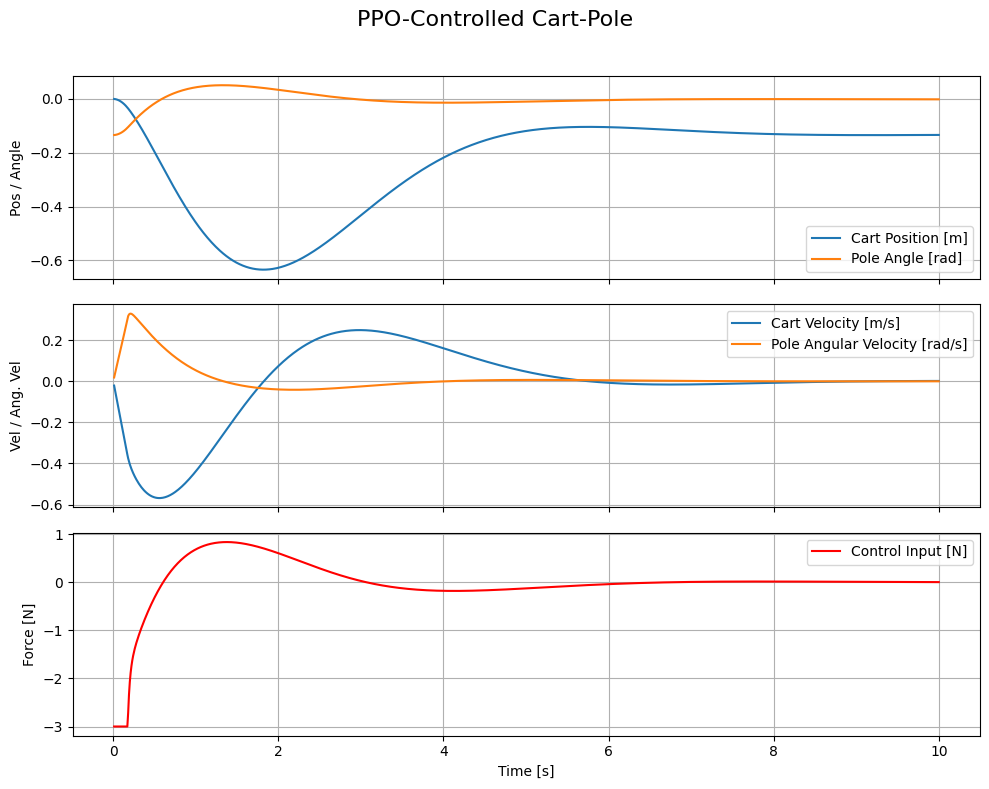

In [10]:
eval_env = CartPoleMuJoCoEnv()
obs, info = eval_env.reset()

duration = 10.0
framerate = 60
max_steps = int(duration / eval_env.dt)

frames = []
times = []
states = []
controls = []

print("Running Evaluation Episode...")
for step in range(max_steps):
    # 학습된 정책(AI)에게 현재 상태를 보여주고 행동(Action)을 결정하게 함
    # deterministic=True: 확률적 탐색을 끄고 가장 좋은 행동만 선택
    action, _ = model.predict(obs, deterministic=True)

    # 환경에 행동 적용
    obs, reward, terminated, truncated, info = eval_env.step(action)

    # 기록
    state = get_state(eval_env.data)
    states.append(state)
    controls.append(float(action[0]))
    times.append(eval_env.data.time)

    # 영상 프레임 저장
    frame = eval_env.render()
    frames.append(frame)

    if terminated or truncated:
        print(f"Episode ended at step {step}")
        break

states = np.vstack(states)
controls = np.array(controls)
times = np.array(times)

print("Evaluation finished. Plotting states...")
plot_states(times, states, controls=controls, title="PPO-Controlled Cart-Pole")

결과 재생

In [11]:
print("Rendering PPO policy video with mediapy...")
media.show_video(frames, fps=framerate)

Rendering PPO policy video with mediapy...
